In [19]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
import pandas as pd

data = pd.read_csv('/content/drive/MyDrive/recommendation/multi-category-dataset-recommendation.csv')
df = data.dropna()

columns_to_keep = ['user_id', 'category_code', 'event_type', 'event_time', 'brand', 'price', 'age', 'gender', 'location']
df = data[columns_to_keep].copy()

split_category = df['category_code'].str.split('.', 1, expand=True)
df['category'] = split_category[0]
df['product_name'] = split_category[1]

df['age'].fillna(df['age'].mean(), inplace=True)

df['event_time'] = pd.to_datetime(df['event_time'], format='%Y-%m-%d %H:%M:%S %Z', utc=True)

print(df.head())

<ipython-input-20-15b7df242e10>:9: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  split_category = df['category_code'].str.split('.', 1, expand=True)


     user_id              category_code event_type                event_time  \
0  520088904     electronics.smartphone       view 2019-11-01 00:00:00+00:00   
1  530496790  appliances.sewing_machine       view 2019-11-01 00:00:00+00:00   
2  561587266                        NaN       view 2019-11-01 00:00:01+00:00   
3  518085591  appliances.kitchen.washer       view 2019-11-01 00:00:01+00:00   
4  558856683     electronics.smartphone       view 2019-11-01 00:00:01+00:00   

    brand   price  age gender       location     category    product_name  
0  xiaomi  489.07   20      M       Northern  electronics      smartphone  
1  janome  293.65   25      M        Central   appliances  sewing_machine  
2   creed   28.31   20      F  North Central          NaN             NaN  
3      lg  712.87   18      M   Sabaragamuwa   appliances  kitchen.washer  
4  xiaomi  183.27   53      M        Eastern  electronics      smartphone  


In [21]:
user_profiles = df.groupby('user_id').agg({
    'age': 'mean',
    'gender': 'first',
    'location': 'first'
}).reset_index()

user_interactions = df[df['event_type'].isin(['view', 'cart', 'purchase'])].groupby('user_id').agg({
    'event_type': 'count'
}).reset_index()

user_interactions.rename(columns={'event_type': 'total_interactions'}, inplace=True)

user_data = pd.merge(user_profiles, user_interactions, on='user_id')

print(user_data.head())


     user_id        age gender       location  total_interactions
0  275256741  51.000000      F  North Western                   1
1  295643776  45.875000      F   Sabaragamuwa                   8
2  356520186  48.166667      F       Southern                   6
3  384989212  21.000000      F   Sabaragamuwa                   1
4  389979783  29.750000      M        Central                   4


In [22]:
product_profiles = df.groupby(['brand', 'category', 'product_name']).agg({
    'price': ['mean', 'min', 'max', 'std', 'count']
}).reset_index()

product_profiles.columns = [' '.join(col).strip() for col in product_profiles.columns.values]

product_profiles.rename(columns={
    'price mean': 'avg_price',
    'price min': 'min_price',
    'price max': 'max_price',
    'price std': 'price_std',
    'price count': 'product_count'
}, inplace=True)

print(product_profiles.head())


  brand     category         product_name   avg_price  min_price  max_price  \
0  acer  accessories                  bag   21.646000      12.07      36.01   
1  acer    computers              desktop  919.270370     192.80    2574.04   
2  acer    computers             notebook  593.541435     257.38    2312.80   
3  acer    computers  peripherals.monitor  233.394433      66.67     725.63   
4  acer  electronics               tablet  179.050625     159.33     194.08   

    price_std  product_count  
0   13.112478              5  
1  768.397437            108  
2  275.868713            676  
3  139.816677             97  
4   14.920438             16  


In [23]:
category_count = df['category'].nunique()

unique_categories = df['category'].unique()

print(f"Category Count: {category_count}")
print("Unique Categories:")
for category in unique_categories:
    print(category)

Category Count: 13
Unique Categories:
electronics
appliances
nan
computers
furniture
apparel
construction
auto
accessories
kids
sport
medicine
country_yard
stationery


In [24]:
!pip install scikit-surprise

In [25]:
from surprise import Reader, Dataset, SVD, accuracy
from surprise.model_selection import train_test_split

event_type_mapping = {
    'view': 1,
    'cart': 2,
    'purchase': 3
}

df['event_type_rating'] = df['event_type'].map(event_type_mapping)

reader = Reader(rating_scale=(1, 3))
data = Dataset.load_from_df(df[['user_id', 'product_name', 'event_type_rating']], reader)

trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

model = SVD()

model.fit(trainset)

predictions = model.test(testset)

rmse = accuracy.rmse(predictions)
mae = accuracy.mae(predictions)

print(f'RMSE: {rmse}')
print(f'MAE: {mae}')

def collaborative_filtering_recommendation(user_id, num_recommendations=5):
    all_product_names = df['product_name'].unique()

    interacted_product_names = df[(df['user_id'] == user_id) & (df['event_type'] == 'purchase')]['product_name'].values

    candidate_product_names = [product_name for product_name in all_product_names if product_name not in interacted_product_names]

    user_ratings = [(user_id, product_name, model.predict(user_id, product_name).est) for product_name in candidate_product_names]

    user_ratings.sort(key=lambda x: x[2], reverse=True)

    top_n_recommendations = user_ratings[:num_recommendations]

    return top_n_recommendations

user_id_to_recommend = 520088904
collaborative_recommendations = collaborative_filtering_recommendation(user_id_to_recommend)

print(f"Collaborative Filtering Recommendations for User {user_id_to_recommend}:")
for _, product_name, estimated_rating in collaborative_recommendations:
    print(f"Product Name: {product_name}, Estimated Rating: {estimated_rating}")

rmse_accuracy = 100 - (rmse * 100)
mae_accuracy = 100 - (mae * 100)

print(f'RMSE Accuracy: {rmse_accuracy:.2f}%')
print(f'MAE Accuracy: {mae_accuracy:.2f}%')




RMSE: 0.2592
MAE:  0.0595
RMSE: 0.2591833929848379
MAE: 0.05945325520639159
Collaborative Filtering Recommendations for User 520088904:
Product Name: camera.video, Estimated Rating: 1.164597573567307
Product Name: tools.soldering, Estimated Rating: 1.13445610539908
Product Name: personal.scales, Estimated Rating: 1.131686453839708
Product Name: accessories.anti_freeze, Estimated Rating: 1.1160004646424448
Product Name: kitchen.steam_cooker, Estimated Rating: 1.115428575796529
RMSE Accuracy: 74.08%
MAE Accuracy: 94.05%


In [26]:
from surprise import dump
import os

# Specify the directory and file name for saving the model
model_dir = 'models'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

svd_model_file = os.path.join(model_dir, 'svd_model.pickle')

# Save the SVD model
dump.dump(svd_model_file, algo=model)
print(f"SVD model saved to {svd_model_file}")


SVD model saved to models/svd_model.pickle


In [27]:
from surprise import Reader, Dataset, NMF, accuracy
from surprise.model_selection import train_test_split

event_type_mapping = {
    'view': 1,
    'cart': 2,
    'purchase': 3
}

df['event_type_rating'] = df['event_type'].map(event_type_mapping)

content_columns = ['user_id', 'product_name', 'event_type_rating', 'brand', 'price', 'category', 'age', 'gender', 'location']

reader = Reader(rating_scale=(1, 3))

def create_custom_dataset(data, reader, columns):
    custom_data = []
    for _, row in data.iterrows():
        custom_data.append((row[columns[0]], row[columns[1]], row[columns[2]]))
    custom_dataset = Dataset.load_from_df(pd.DataFrame(custom_data, columns=['user', 'item', 'rating']), reader)
    return custom_dataset

data = create_custom_dataset(df, reader, content_columns)

trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

content_model = NMF()

content_model.fit(trainset)

content_predictions = content_model.test(testset)

content_rmse = accuracy.rmse(content_predictions)
content_mae = accuracy.mae(content_predictions)

print(f'Content-Based RMSE: {content_rmse:.4f}')
print(f'Content-Based MAE: {content_mae:.4f}')

def content_filtering_recommendation(user_id, num_recommendations=5):
    all_product_names = df['product_name'].unique()
    interacted_product_names = df[(df['user_id'] == user_id) & (df['event_type'] == 'purchase')]['product_name'].values
    candidate_product_names = [product_name for product_name in all_product_names if product_name not in interacted_product_names]
    user_ratings = [(user_id, product_name, content_model.predict(user_id, product_name).est) for product_name in candidate_product_names]
    user_ratings.sort(key=lambda x: x[2], reverse=True)
    top_n_recommendations = user_ratings[:num_recommendations]
    return top_n_recommendations

user_id_to_recommend = 520088904
content_recommendations = content_filtering_recommendation(user_id_to_recommend)

print(f"Content-Based Recommendations for User {user_id_to_recommend}:")
for _, product_name, estimated_rating in content_recommendations:
    print(f"Product Name: {product_name}, Estimated Rating: {estimated_rating:.4f}")

content_rmse_accuracy = 100 - (content_rmse * 100)
content_mae_accuracy = 100 - (content_mae * 100)

print(f'Content-Based RMSE Accuracy: {content_rmse_accuracy:.2f}%')
print(f'Content-Based MAE Accuracy: {content_mae_accuracy:.2f}%')


RMSE: 0.2817
MAE:  0.0667
Content-Based RMSE: 0.2817
Content-Based MAE: 0.0667
Content-Based Recommendations for User 520088904:
Product Name: smartphone, Estimated Rating: 1.0000
Product Name: sewing_machine, Estimated Rating: 1.0000
Product Name: nan, Estimated Rating: 1.0000
Product Name: kitchen.washer, Estimated Rating: 1.0000
Product Name: notebook, Estimated Rating: 1.0000
Content-Based RMSE Accuracy: 71.83%
Content-Based MAE Accuracy: 93.33%


In [28]:
nmf_model_file = os.path.join(model_dir, 'nmf_model.pickle')

# Save the NMF model
dump.dump(nmf_model_file, algo=content_model)
print(f"NMF model saved to {nmf_model_file}")


NMF model saved to models/nmf_model.pickle


In [29]:
# Combine and prioritize recommendations (example: merge and sort)
def hybrid_recommendation(user_id, num_recommendations=5):
    collaborative_recommendations = collaborative_filtering_recommendation(user_id, num_recommendations)
    content_recommendations = content_filtering_recommendation(user_id, num_recommendations)

    hybrid_recommendations = sorted(collaborative_recommendations + content_recommendations, key=lambda x: x[2], reverse=True)

    return hybrid_recommendations

user_id_to_recommend = 520088904
recommendations = hybrid_recommendation(user_id_to_recommend)

print(f"Hybrid Recommendations for User {user_id_to_recommend}:")
for _, product_name, estimated_rating in recommendations:
    print(f"Product Name: {product_name}, Estimated Rating: {estimated_rating:.4f}")

hybrid_rmse = accuracy.rmse(predictions, verbose=False)
hybrid_mae = accuracy.mae(predictions, verbose=False)

hybrid_rmse_accuracy = 100 - (hybrid_rmse * 100)
hybrid_mae_accuracy = 100 - (hybrid_mae * 100)

print(f'Hybrid RMSE Accuracy: {hybrid_rmse_accuracy:.2f}%')
print(f'Hybrid MAE Accuracy: {hybrid_mae_accuracy:.2f}%')

Hybrid Recommendations for User 520088904:
Product Name: camera.video, Estimated Rating: 1.1646
Product Name: tools.soldering, Estimated Rating: 1.1345
Product Name: personal.scales, Estimated Rating: 1.1317
Product Name: accessories.anti_freeze, Estimated Rating: 1.1160
Product Name: kitchen.steam_cooker, Estimated Rating: 1.1154
Product Name: smartphone, Estimated Rating: 1.0000
Product Name: sewing_machine, Estimated Rating: 1.0000
Product Name: nan, Estimated Rating: 1.0000
Product Name: kitchen.washer, Estimated Rating: 1.0000
Product Name: notebook, Estimated Rating: 1.0000
Hybrid RMSE Accuracy: 74.08%
Hybrid MAE Accuracy: 94.05%


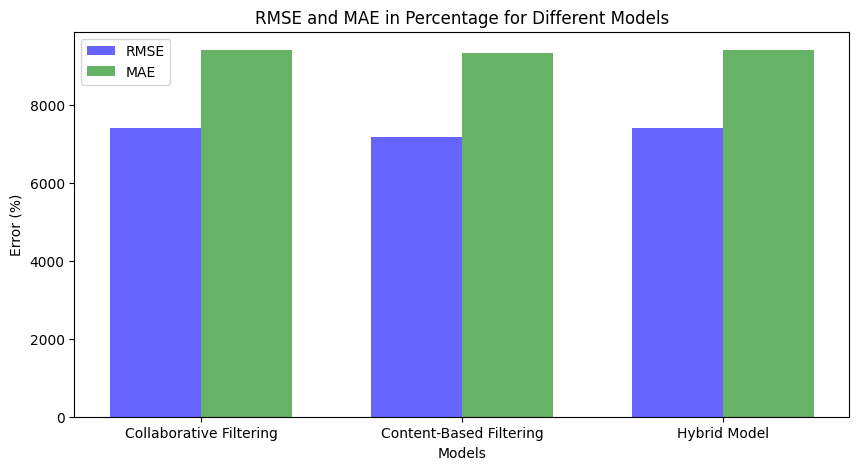

In [30]:
import matplotlib.pyplot as plt

models = ['Collaborative Filtering', 'Content-Based Filtering', 'Hybrid Model']
rmse_values = [rmse_accuracy, content_rmse_accuracy, hybrid_rmse_accuracy]
mae_values = [mae_accuracy, content_mae_accuracy, hybrid_mae_accuracy]

rmse_values_percentage = [value * 100 for value in rmse_values]
mae_values_percentage = [value * 100 for value in mae_values]

# Create bar plots for RMSE and MAE in percentage
plt.figure(figsize=(10, 5))
bar_width = 0.35
index = range(len(models))
plt.bar(index, rmse_values_percentage, bar_width, color='b', alpha=0.6, label='RMSE')
plt.bar([i + bar_width for i in index], mae_values_percentage, bar_width, color='g', alpha=0.6, label='MAE')
plt.xlabel('Models')
plt.ylabel('Error (%)')
plt.title('RMSE and MAE in Percentage for Different Models')
plt.xticks([i + bar_width / 2 for i in index], models)
plt.legend()
plt.show()

#solve cold start problem

In [31]:
# Define a function to provide hybrid recommendations for users, considering existing, new users, and new items
def hybrid_recommendation(user_id, num_recommendations=5):
    if user_id in user_data['user_id'].unique():
        collaborative_recommendations = collaborative_filtering_recommendation(user_id, num_recommendations)
        return collaborative_recommendations

    # Check if the user is a new user with demographic data
    if user_id in new_users['user_id'].unique():
        new_user_profile = new_users[new_users['user_id'] == user_id].iloc[0]
        new_user_recommendations = recommend_for_new_user(new_user_profile['age'], new_user_profile['gender'], new_user_profile['location'], num_recommendations)
        return new_user_recommendations

    # New item: Use content-based filtering based on item characteristics
    new_item_profile = new_items[new_items['product_name'] == user_id].iloc[0]
    new_item_recommendations = recommend_for_new_item(new_item_profile['brand'], new_item_profile['category'], new_item_profile['price'], num_recommendations)
    return new_item_recommendations

user_id_to_recommend = 520088904
recommendations = hybrid_recommendation(user_id_to_recommend)

print(f"Hybrid Recommendations for User {user_id_to_recommend}:")
print(recommendations)


Hybrid Recommendations for User 520088904:
[(520088904, 'camera.video', 1.164597573567307), (520088904, 'tools.soldering', 1.13445610539908), (520088904, 'personal.scales', 1.131686453839708), (520088904, 'accessories.anti_freeze', 1.1160004646424448), (520088904, 'kitchen.steam_cooker', 1.115428575796529)]
